In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import requests
import numpy as np
import math
import gc
import json
import re
import keplergl as kp
import glob
import os
import ast
import seaborn as sns

from pymeos import *
from tqdm.notebook import tqdm
from shapely.geometry import LineString, Point
from sklearn import metrics
from scipy import stats
from ast import literal_eval
from geopy.distance import geodesic
from itertools import groupby
from operator import itemgetter

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, KFold, cross_validate, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

In [2]:
%matplotlib inline
sns.set(rc = {'figure.figsize': (8,5)})

### Importing result

In [3]:
reg_df = pd.read_csv('../results/regression_results_trip.csv')
reg_15_df = pd.read_csv('../results/regression__individual_results_trip.csv')
lstm_df = pd.read_csv('../results/lstm_prediction_trips.csv')
# avg_df = pd.read_csv('average.csv')

#### Combining data

In [4]:
columns = ['vehicle', 'date', 'y_pred', 'y', 'trip_id', 'times', 'weathers']
result_df = pd.merge(reg_df[columns], reg_15_df[['y_pred', 'y']], left_index=True, right_index=True).rename(columns={
    'y_pred_x': 'Unified Vehicle Model',
    'y_pred_y': 'Individual Vehicle Model',
    'y_x': 'y'
}).drop(columns=['y_y'])
# result_df = pd.merge(result_df, avg_df[['average']], left_index=True, right_index=True)
result_df = pd.merge(result_df, lstm_df[['y_pred']], left_index=True, right_index=True).rename(columns={'y_pred': 'LSTM'})
# result_df = result_df[result_df['trip_id'] != 'E307_2024-01-28_trip_53']
result_df = result_df.drop(columns=['times', 'weathers'])

### Overal performance

In [14]:
preds = ['Unified Vehicle Model', 'Individual Vehicle Model', 'LSTM']

overall = {'model': [], 'rmse': [], 'mape': [], 'std': [], 'variance': []}
for pred in preds:
    mse = metrics.mean_squared_error(result_df['y'], result_df[pred])
    mae = metrics.mean_absolute_error(result_df['y'], result_df[pred])
    r2 = metrics.r2_score(result_df['y'], result_df[pred])

    std = np.std(result_df['y'] - result_df[pred])
    
    print(f"Model {pred}, Overall RMSE: {math.sqrt(mse)}, r2: {r2}, std: {std}, mae: {mae}")

Model Unified Vehicle Model, Overall RMSE: 2.21334605476205, r2: 0.4911701414460805, std: 2.2067709378346403, mae: 1.7005878936412349
Model Individual Vehicle Model, Overall RMSE: 2.2858996145300465, r2: 0.4572644676524027, std: 2.2845079280423684, mae: 1.7684647984569788
Model LSTM, Overall RMSE: 1.3159582281244375, r2: 0.8201302403673586, std: 1.3154711365500134, mae: 0.9945845182272727


In [5]:
dataset = pd.read_csv('../processed_data/dataset_cleaned_v5.csv')
dataset['t'] = pd.to_datetime(dataset['t'])
dataset['date'] = dataset['t'].dt.date
dataset['vehicle'] = dataset['vehicle'].astype(str)
dataset['road_segment_id'] = dataset['road_segment_id'].astype(str)
dataset = dataset.drop(columns=['segment_id', 'snowfall', 'est_segment_battery_consumption(kwh)', 'sunshine_duration', 'rain', 'soil_moisture_0_to_7cm', 'soil_temperature_0_to_7cm', 'datetime', 'speed_meos'])

dataset['stop'] = dataset['trip_id'].str.contains('stop')
dataset['unique_trip_id'] = dataset['vehicle'].astype(str) + '_' + dataset['date'].astype(str) + '_' + dataset['trip_id'].astype(str)
dataset = dataset.drop(columns=['trip_id'])

In [6]:
preds = ['Unified Vehicle Model', 'Individual Vehicle Model', 'LSTM']

overall = {'model': [], 'rmse': [], 'mape': [], 'std': [], 'variance': []}
for pred in preds:
    mse = metrics.mean_squared_error(result_df['y'], result_df[pred])
    mape = metrics.mean_absolute_percentage_error(result_df['y'], result_df[pred])
    r2 = metrics.r2_score(result_df['y'], result_df[pred])
    std = np.std(result_df['y'] - result_df[pred])
    
    n = 75281 # Number of samples
    p = 16 # Number of features

    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

    
    print(f"Model {pred}, Overall RMSE: {math.sqrt(mse)}, r2: {adjusted_r2}, std: {std}")

Model Unified Vehicle Model, Overall RMSE: 2.21334605476205, r2: 0.4910619718332927, std: 2.2067709378346403
Model Individual Vehicle Model, Overall RMSE: 2.2858996145300465, r2: 0.4571490902007982, std: 2.2845079280423684
Model LSTM, Overall RMSE: 1.3159582281244375, r2: 0.8200920027483891, std: 1.3154711365500134


In [19]:
result_df.sort_values(['y'], ascending=False).head()

,vehicle,date,Unified Vehicle Model,y,trip_id,Individual Vehicle Model,LSTM
873,E314,2024-01-22,31.972746,38.0,E314_2024-01-22_trip_97,29.408958,36.920340
1061,E316,2024-02-01,27.618476,32.0,E316_2024-02-01_trip_93,24.833120,30.528120
372,E307,2024-01-28,14.163727,23.0,E307_2024-01-28_trip_53,13.959532,12.024569
362,E307,2024-01-27,26.584519,22.0,E307_2024-01-27_trip_0,26.472815,25.413673
594,E310,2024-01-24,16.989899,22.0,E310_2024-01-24_trip_295,16.951611,19.154400


In [20]:
dataset

,vehicle,t,road_segment_id,est_battery_consumption(kwh),date,segment_length,distance_traveled,temperature_2m,relative_humidity_2m,precipitation,wind_speed_10m,wind_direction_10m,is_day,mean_elevation,avg_grade,avg_angle,geometry,stop,unique_trip_id
0,E301,2024-01-21 08:49:19,553983725,1.000000,2024-01-21,14.361187,1.625764,4.683000,29.58425,0.0,10.483357,15.945477,1.0,8.699299,-1.343470,-0.769706,LINESTRING Z (8.9455802 44.400228 8.7958431243...,False,E301_2024-01-21_trip_20
1,E301,2024-01-21 08:49:49,211285373,0.199855,2024-01-21,63.803733,43.126976,4.683000,29.58425,0.0,10.483357,15.945477,1.0,8.543800,-0.184659,-0.105802,LINESTRING Z (8.9456338 44.4003515 8.602755546...,False,E301_2024-01-21_trip_20
2,E301,2024-01-21 08:49:49,19784065,0.227071,2024-01-21,48.896393,49.000000,4.683000,29.58425,0.0,10.483357,15.945477,1.0,8.391276,-0.414343,-0.237398,LINESTRING Z (8.945892 44.4008955 8.4848451614...,False,E301_2024-01-21_trip_20
3,E301,2024-01-21 08:49:49,474230989,0.064877,2024-01-21,13.874596,14.000000,4.683000,29.58425,0.0,10.483357,15.945477,1.0,8.100567,-1.743121,-0.998634,LINESTRING Z (8.9460857 44.4013134 8.221586227...,False,E301_2024-01-21_trip_20
4,E301,2024-01-21 08:50:19,553819742,0.508197,2024-01-21,74.361373,54.949292,4.683000,29.58425,0.0,10.483357,15.945477,1.0,7.554913,-0.185431,-0.106138,LINESTRING Z (8.946138 44.4014326 7.9795479774...,False,E301_2024-01-21_trip_20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264993,E316,2024-02-09 20:59:31,24313581,0.086648,2024-02-09,170.122166,116.095320,11.733000,89.32021,1.8,23.006226,159.863620,0.0,7.030001,-1.636248,-0.937297,LINESTRING Z (8.9517899 44.4044109 8.780200958...,False,E316_2024-02-09_trip_490
264994,E316,2024-02-09 21:00:01,136531734,0.044034,2024-02-09,145.945283,82.290272,12.082999,87.57585,2.5,24.905132,184.144550,0.0,4.867664,-1.057230,-0.605723,LINESTRING Z (8.9511136 44.4029576 5.404003143...,False,E316_2024-02-09_trip_490
264995,E316,2024-02-09 21:01:03,274100607,0.060344,2024-02-09,97.871372,58.727186,12.082999,87.57585,2.5,24.905132,184.144550,0.0,3.865974,-1.577247,-0.903525,LINESTRING Z (8.9505306 44.4017114 4.052059173...,False,E316_2024-02-09_trip_490
264996,E316,2024-02-09 21:01:03,274100606,0.029994,2024-02-09,108.217493,108.000000,12.082999,87.57585,2.5,24.905132,184.144550,0.0,3.217747,-0.013462,-0.007713,LINESTRING Z (8.9501388 44.4008759 3.629924058...,False,E316_2024-02-09_trip_490


In [7]:
info = dataset.groupby('unique_trip_id').aggregate({
    't': list,
    'precipitation': 'mean',
    'temperature_2m': 'mean',
    'distance_traveled': 'sum',
}).reset_index()
info['start_time'] = info['t'].apply(lambda x: min(x))
info['end_time'] =  info['t'].apply(lambda x: max(x))
info = info.rename(columns={'unique_trip_id': 'trip_id'}).drop(columns=['t'])
info

,trip_id,precipitation,temperature_2m,distance_traveled,start_time,end_time
0,E301_2024-01-21_stop_110,0.000000,10.533000,124.716344,2024-01-21 10:07:52,2024-01-21 10:25:14
1,E301_2024-01-21_stop_165,0.000000,10.892999,141.007459,2024-01-21 10:54:47,2024-01-21 11:04:57
2,E301_2024-01-21_stop_234,0.000000,11.132999,146.246617,2024-01-21 11:41:16,2024-01-21 11:50:25
3,E301_2024-01-21_stop_298,0.000000,11.033000,161.322076,2024-01-21 12:23:35,2024-01-21 12:31:15
4,E301_2024-01-21_stop_371,0.000000,10.933000,88.861508,2024-01-21 13:09:30,2024-01-21 13:10:32
...,...,...,...,...,...,...
7060,E316_2024-02-09_trip_447,1.633333,11.744111,3333.768698,2024-02-09 18:39:26,2024-02-09 19:03:57
7061,E316_2024-02-09_trip_465,2.100000,11.783000,2750.521038,2024-02-09 19:13:37,2024-02-09 19:38:39
7062,E316_2024-02-09_trip_490,1.863784,11.748676,9157.421779,2024-02-09 19:51:57,2024-02-09 21:01:03
7063,E316_2024-02-09_trip_61,1.625000,12.393416,3017.711959,2024-02-09 06:55:02,2024-02-09 07:09:25


In [8]:
info['duration'] = info.apply(lambda row: row['end_time'] - row['start_time'], axis=1)

In [9]:
info = info[~info['trip_id'].str.contains('stop')]
info

,trip_id,precipitation,temperature_2m,distance_traveled,start_time,end_time,duration
13,E301_2024-01-21_trip_118,0.000000,11.132999,4102.677273,2024-01-21 11:07:30,2024-01-21 11:40:46,0 days 00:33:16
14,E301_2024-01-21_trip_137,0.000000,11.064250,3534.905279,2024-01-21 11:51:26,2024-01-21 12:23:04,0 days 00:31:38
15,E301_2024-01-21_trip_153,0.000000,11.000089,4008.197566,2024-01-21 12:34:50,2024-01-21 13:08:59,0 days 00:34:09
16,E301_2024-01-21_trip_166,0.000000,10.933000,3971.421701,2024-01-21 13:16:08,2024-01-21 13:46:11,0 days 00:30:03
17,E301_2024-01-21_trip_176,0.000000,10.796953,4211.510773,2024-01-21 13:54:49,2024-01-21 14:34:10,0 days 00:39:21
...,...,...,...,...,...,...,...
7060,E316_2024-02-09_trip_447,1.633333,11.744111,3333.768698,2024-02-09 18:39:26,2024-02-09 19:03:57,0 days 00:24:31
7061,E316_2024-02-09_trip_465,2.100000,11.783000,2750.521038,2024-02-09 19:13:37,2024-02-09 19:38:39,0 days 00:25:02
7062,E316_2024-02-09_trip_490,1.863784,11.748676,9157.421779,2024-02-09 19:51:57,2024-02-09 21:01:03,0 days 01:09:06
7063,E316_2024-02-09_trip_61,1.625000,12.393416,3017.711959,2024-02-09 06:55:02,2024-02-09 07:09:25,0 days 00:14:23


/tmp/ipykernel_36312/2195093865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['duration_in_minutes'] = info['duration'].dt.total_seconds() / 60


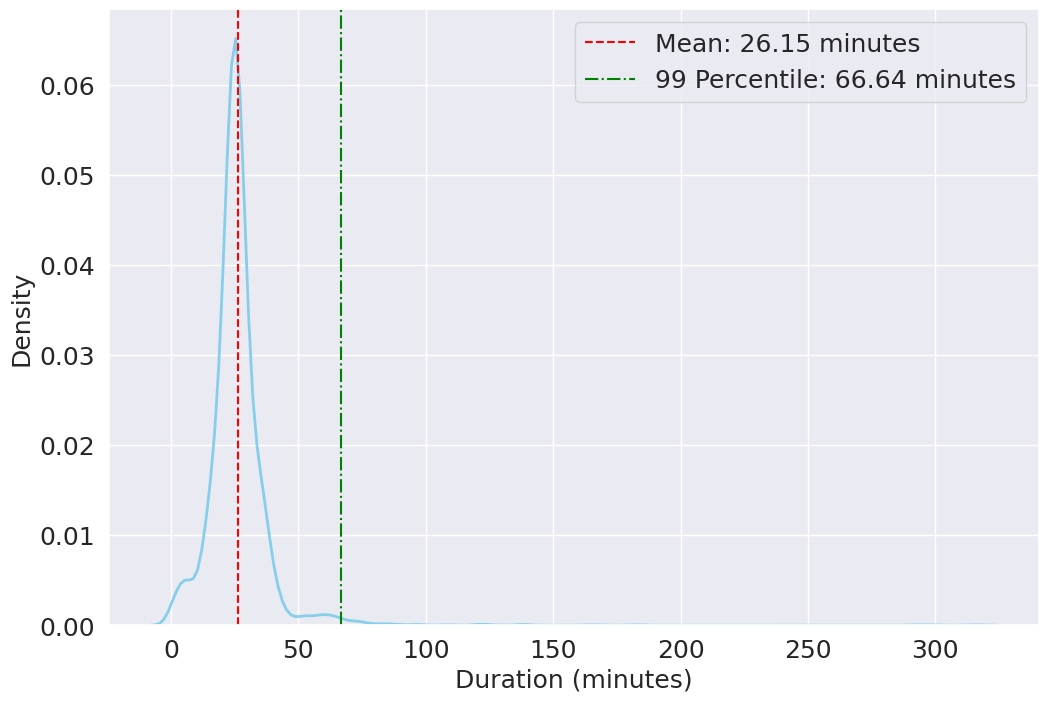

In [58]:

info['duration_in_minutes'] = info['duration'].dt.total_seconds() / 60

# Re-plotting with the duration now in minutes
plt.figure(figsize=(12, 8))
sns.kdeplot(info['duration_in_minutes'], color="skyblue", linewidth=2)

# Plotting the mean
mean_val = info['duration_in_minutes'].mean()
p99_val = info['duration_in_minutes'].quantile(0.99)

plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f} minutes')
plt.axvline(p99_val, color='green', linestyle='-.', label=f'99 Percentile: {p99_val:.2f} minutes')

# Labels and title
plt.title('')
plt.xlabel('Duration (minutes)', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.savefig('density_duration.svg', format='svg')
# Show plot
plt.show()

/tmp/ipykernel_36312/3010746469.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['distance_in_km'] = info['distance_traveled'] / 1000


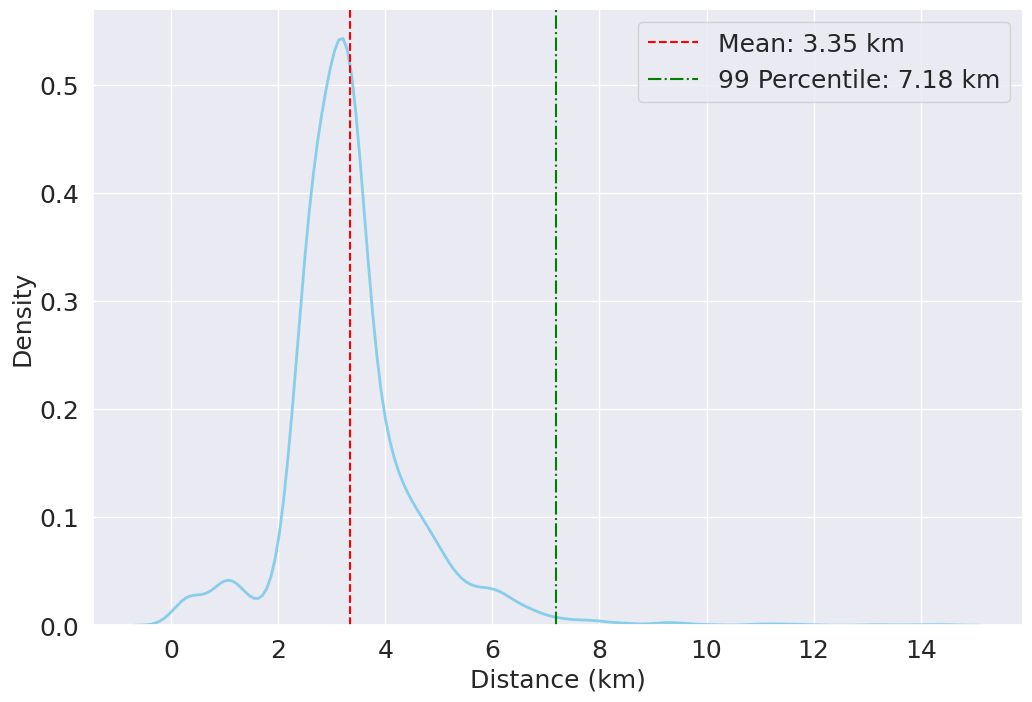

In [59]:
info['distance_in_km'] = info['distance_traveled'] / 1000

# Re-plotting with the duration now in minutes
plt.figure(figsize=(12, 8))
sns.kdeplot(info['distance_in_km'], color="skyblue", linewidth=2)

# Plotting the mean
mean_val = info['distance_in_km'].mean()
p99_val = info['distance_in_km'].quantile(0.99)

plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f} km')
plt.axvline(p99_val, color='green', linestyle='-.', label=f'99 Percentile: {p99_val:.2f} km')

# Labels and title
plt.title('')
plt.xlabel('Distance (km)', fontsize=18)
plt.ylabel('Density',  fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.savefig('density_distance.svg', format='svg')
# Show plot
plt.show()

In [19]:
result_df = pd.merge(result_df, info, on=['trip_id'])

In [20]:
# Convert start_time to datetime
result_df['start_time'] = pd.to_datetime(result_df['start_time'])

# Binning start_time by hour and extracting only the time part
result_df['start_time_hour_bin'] = result_df['start_time'].dt.floor('H').dt.time


# Define the precipitation bins
conditions = [
    (result_df['precipitation'] == 0),
    (result_df['precipitation'] > 0) & (result_df['precipitation'] < 2.5),
    (result_df['precipitation'] >= 2.5) & (result_df['precipitation'] <= 7.6),
    (result_df['precipitation'] > 7.6) & (result_df['precipitation'] <= 50),
    (result_df['precipitation'] > 50)
]
choices = ['No Rain', 'Light Rain', 'Moderate Rain', 'Heavy Rain', 'Violent Rain']

result_df['precipitation_bin'] = np.select(conditions, choices, default='Unknown')

# Binning temperature_2m by 1-degree intervals
result_df['temperature_bin'] = pd.cut(result_df['temperature_2m'], bins=np.arange(np.floor(result_df['temperature_2m'].min()), 
                                             np.ceil(result_df['temperature_2m'].max()) + 1, 1))

result_df

/tmp/ipykernel_36312/1478289224.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  result_df['start_time_hour_bin'] = result_df['start_time'].dt.floor('H').dt.time


,vehicle,date,Unified Vehicle Model,y,trip_id,Individual Vehicle Model,LSTM,precipitation,temperature_2m,distance_traveled,start_time,end_time,duration,duration_in_minutes,distance_in_km,start_time_hour_bin,precipitation_bin,temperature_bin
0,E301,2024-01-21,10.712876,11.0,E301_2024-01-21_trip_118,9.936776,8.502107,0.000000,11.132999,4102.677273,2024-01-21 11:07:30,2024-01-21 11:40:46,0 days 00:33:16,33.266667,4.102677,11:00:00,No Rain,"(11.0, 12.0]"
1,E301,2024-01-21,2.681670,5.0,E301_2024-01-21_trip_226,2.686769,5.141864,0.000000,10.082999,1362.885103,2024-01-21 15:15:36,2024-01-21 15:22:13,0 days 00:06:37,6.616667,1.362885,15:00:00,No Rain,"(10.0, 11.0]"
2,E301,2024-01-21,10.598989,8.0,E301_2024-01-21_trip_62,10.110810,7.741240,0.000000,8.744250,4750.950919,2024-01-21 09:40:21,2024-01-21 10:07:21,0 days 00:27:00,27.000000,4.750951,09:00:00,No Rain,"(8.0, 9.0]"
3,E301,2024-01-23,5.249688,7.0,E301_2024-01-23_trip_157,5.744896,7.957819,0.000000,7.333000,2390.914441,2024-01-23 07:33:55,2024-01-23 07:58:26,0 days 00:24:31,24.516667,2.390914,07:00:00,No Rain,"(7.0, 8.0]"
4,E301,2024-01-23,5.600924,8.0,E301_2024-01-23_trip_210,6.316638,6.498373,0.000000,11.632999,3272.966470,2024-01-23 09:22:03,2024-01-23 09:50:13,0 days 00:28:10,28.166667,3.272966,09:00:00,No Rain,"(11.0, 12.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,E316,2024-02-09,6.091781,8.0,E316_2024-02-09_trip_373,5.956568,7.317472,2.594737,12.070719,2861.344672,2024-02-09 16:41:34,2024-02-09 17:06:04,0 days 00:24:30,24.500000,2.861345,16:00:00,Moderate Rain,"(12.0, 13.0]"
1096,E316,2024-02-09,0.912428,0.0,E316_2024-02-09_trip_425,0.856928,0.521374,1.900000,11.845500,476.364862,2024-02-09 17:59:00,2024-02-09 18:03:36,0 days 00:04:36,4.600000,0.476365,17:00:00,Light Rain,"(11.0, 12.0]"
1097,E316,2024-02-09,4.720329,7.0,E316_2024-02-09_trip_438,4.347574,6.052791,1.500000,11.733000,2082.621104,2024-02-09 18:11:47,2024-02-09 18:32:47,0 days 00:21:00,21.000000,2.082621,18:00:00,Light Rain,"(11.0, 12.0]"
1098,E316,2024-02-09,15.312041,12.0,E316_2024-02-09_trip_490,17.420046,14.649944,1.863784,11.748676,9157.421779,2024-02-09 19:51:57,2024-02-09 21:01:03,0 days 01:09:06,69.100000,9.157422,19:00:00,Light Rain,"(11.0, 12.0]"


In [21]:
result_df['duration'] = result_df.apply(lambda row: row['end_time'] - row['start_time'], axis=1)

In [22]:
# Assuming duration is already in timedelta format, otherwise convert it:
result_df['duration'] = pd.to_timedelta(result_df['duration'])

# Convert duration to total minutes
result_df['duration_in_minutes'] = result_df['duration'].dt.total_seconds() / 60

# Define the bin edges - every 10 minutes
bins = range(0, int(result_df['duration_in_minutes'].max()) + 10, 10)

# Bin the duration in minutes
result_df['duration_binned'] = pd.cut(result_df['duration_in_minutes'], bins=bins, include_lowest=True)

result_df

,vehicle,date,Unified Vehicle Model,y,trip_id,Individual Vehicle Model,LSTM,precipitation,temperature_2m,distance_traveled,start_time,end_time,duration,duration_in_minutes,distance_in_km,start_time_hour_bin,precipitation_bin,temperature_bin,duration_binned
0,E301,2024-01-21,10.712876,11.0,E301_2024-01-21_trip_118,9.936776,8.502107,0.000000,11.132999,4102.677273,2024-01-21 11:07:30,2024-01-21 11:40:46,0 days 00:33:16,33.266667,4.102677,11:00:00,No Rain,"(11.0, 12.0]","(30.0, 40.0]"
1,E301,2024-01-21,2.681670,5.0,E301_2024-01-21_trip_226,2.686769,5.141864,0.000000,10.082999,1362.885103,2024-01-21 15:15:36,2024-01-21 15:22:13,0 days 00:06:37,6.616667,1.362885,15:00:00,No Rain,"(10.0, 11.0]","(-0.001, 10.0]"
2,E301,2024-01-21,10.598989,8.0,E301_2024-01-21_trip_62,10.110810,7.741240,0.000000,8.744250,4750.950919,2024-01-21 09:40:21,2024-01-21 10:07:21,0 days 00:27:00,27.000000,4.750951,09:00:00,No Rain,"(8.0, 9.0]","(20.0, 30.0]"
3,E301,2024-01-23,5.249688,7.0,E301_2024-01-23_trip_157,5.744896,7.957819,0.000000,7.333000,2390.914441,2024-01-23 07:33:55,2024-01-23 07:58:26,0 days 00:24:31,24.516667,2.390914,07:00:00,No Rain,"(7.0, 8.0]","(20.0, 30.0]"
4,E301,2024-01-23,5.600924,8.0,E301_2024-01-23_trip_210,6.316638,6.498373,0.000000,11.632999,3272.966470,2024-01-23 09:22:03,2024-01-23 09:50:13,0 days 00:28:10,28.166667,3.272966,09:00:00,No Rain,"(11.0, 12.0]","(20.0, 30.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,E316,2024-02-09,6.091781,8.0,E316_2024-02-09_trip_373,5.956568,7.317472,2.594737,12.070719,2861.344672,2024-02-09 16:41:34,2024-02-09 17:06:04,0 days 00:24:30,24.500000,2.861345,16:00:00,Moderate Rain,"(12.0, 13.0]","(20.0, 30.0]"
1096,E316,2024-02-09,0.912428,0.0,E316_2024-02-09_trip_425,0.856928,0.521374,1.900000,11.845500,476.364862,2024-02-09 17:59:00,2024-02-09 18:03:36,0 days 00:04:36,4.600000,0.476365,17:00:00,Light Rain,"(11.0, 12.0]","(-0.001, 10.0]"
1097,E316,2024-02-09,4.720329,7.0,E316_2024-02-09_trip_438,4.347574,6.052791,1.500000,11.733000,2082.621104,2024-02-09 18:11:47,2024-02-09 18:32:47,0 days 00:21:00,21.000000,2.082621,18:00:00,Light Rain,"(11.0, 12.0]","(20.0, 30.0]"
1098,E316,2024-02-09,15.312041,12.0,E316_2024-02-09_trip_490,17.420046,14.649944,1.863784,11.748676,9157.421779,2024-02-09 19:51:57,2024-02-09 21:01:03,0 days 01:09:06,69.100000,9.157422,19:00:00,Light Rain,"(11.0, 12.0]","(60.0, 70.0]"


In [23]:
# Define the bin edges - every 5 units
y_min = result_df['y'].min() - (result_df['y'].min() % 5)  # Adjust min to be a multiple of 5
y_max = result_df['y'].max() + (5 - result_df['y'].max() % 5)  # Adjust max to be a multiple of 5

bins = range(int(y_min), int(y_max) + 5, 5)

# Bin the y values into intervals of 5
result_df['y_binned'] = pd.cut(result_df['y'], bins=bins, include_lowest=True)

# Convert the intervals to strings
result_df['y_binned'] = result_df['y_binned'].apply(
    lambda x: f"{int(x.left)} - {int(x.right)}"
)

result_df

,vehicle,date,Unified Vehicle Model,y,trip_id,Individual Vehicle Model,LSTM,precipitation,temperature_2m,distance_traveled,start_time,end_time,duration,duration_in_minutes,distance_in_km,start_time_hour_bin,precipitation_bin,temperature_bin,duration_binned,y_binned
0,E301,2024-01-21,10.712876,11.0,E301_2024-01-21_trip_118,9.936776,8.502107,0.000000,11.132999,4102.677273,2024-01-21 11:07:30,2024-01-21 11:40:46,0 days 00:33:16,33.266667,4.102677,11:00:00,No Rain,"(11.0, 12.0]","(30.0, 40.0]",10 - 15
1,E301,2024-01-21,2.681670,5.0,E301_2024-01-21_trip_226,2.686769,5.141864,0.000000,10.082999,1362.885103,2024-01-21 15:15:36,2024-01-21 15:22:13,0 days 00:06:37,6.616667,1.362885,15:00:00,No Rain,"(10.0, 11.0]","(-0.001, 10.0]",0 - 5
2,E301,2024-01-21,10.598989,8.0,E301_2024-01-21_trip_62,10.110810,7.741240,0.000000,8.744250,4750.950919,2024-01-21 09:40:21,2024-01-21 10:07:21,0 days 00:27:00,27.000000,4.750951,09:00:00,No Rain,"(8.0, 9.0]","(20.0, 30.0]",5 - 10
3,E301,2024-01-23,5.249688,7.0,E301_2024-01-23_trip_157,5.744896,7.957819,0.000000,7.333000,2390.914441,2024-01-23 07:33:55,2024-01-23 07:58:26,0 days 00:24:31,24.516667,2.390914,07:00:00,No Rain,"(7.0, 8.0]","(20.0, 30.0]",5 - 10
4,E301,2024-01-23,5.600924,8.0,E301_2024-01-23_trip_210,6.316638,6.498373,0.000000,11.632999,3272.966470,2024-01-23 09:22:03,2024-01-23 09:50:13,0 days 00:28:10,28.166667,3.272966,09:00:00,No Rain,"(11.0, 12.0]","(20.0, 30.0]",5 - 10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,E316,2024-02-09,6.091781,8.0,E316_2024-02-09_trip_373,5.956568,7.317472,2.594737,12.070719,2861.344672,2024-02-09 16:41:34,2024-02-09 17:06:04,0 days 00:24:30,24.500000,2.861345,16:00:00,Moderate Rain,"(12.0, 13.0]","(20.0, 30.0]",5 - 10
1096,E316,2024-02-09,0.912428,0.0,E316_2024-02-09_trip_425,0.856928,0.521374,1.900000,11.845500,476.364862,2024-02-09 17:59:00,2024-02-09 18:03:36,0 days 00:04:36,4.600000,0.476365,17:00:00,Light Rain,"(11.0, 12.0]","(-0.001, 10.0]",0 - 5
1097,E316,2024-02-09,4.720329,7.0,E316_2024-02-09_trip_438,4.347574,6.052791,1.500000,11.733000,2082.621104,2024-02-09 18:11:47,2024-02-09 18:32:47,0 days 00:21:00,21.000000,2.082621,18:00:00,Light Rain,"(11.0, 12.0]","(20.0, 30.0]",5 - 10
1098,E316,2024-02-09,15.312041,12.0,E316_2024-02-09_trip_490,17.420046,14.649944,1.863784,11.748676,9157.421779,2024-02-09 19:51:57,2024-02-09 21:01:03,0 days 01:09:06,69.100000,9.157422,19:00:00,Light Rain,"(11.0, 12.0]","(60.0, 70.0]",10 - 15


In [24]:
result_df[result_df['y_binned'] == '20 - 25']

,vehicle,date,Unified Vehicle Model,y,trip_id,Individual Vehicle Model,LSTM,precipitation,temperature_2m,distance_traveled,start_time,end_time,duration,duration_in_minutes,distance_in_km,start_time_hour_bin,precipitation_bin,temperature_bin,duration_binned,y_binned
262,E306,2024-01-23,16.195803,21.0,E306_2024-01-23_trip_177,17.125052,23.368208,0.0,8.575708,9205.475725,2024-01-23 07:40:07,2024-01-23 09:05:20,0 days 01:25:13,85.216667,9.205476,07:00:00,No Rain,"(8.0, 9.0]","(80.0, 90.0]",20 - 25
362,E307,2024-01-27,26.584519,22.0,E307_2024-01-27_trip_0,26.472815,25.413673,0.0,10.348209,14404.927006,2024-01-27 07:56:02,2024-01-27 09:25:03,0 days 01:29:01,89.016667,14.404927,07:00:00,No Rain,"(10.0, 11.0]","(80.0, 90.0]",20 - 25
372,E307,2024-01-28,14.163727,23.0,E307_2024-01-28_trip_53,13.959532,12.024569,0.0,15.651796,6055.323646,2024-01-28 12:24:28,2024-01-28 13:14:32,0 days 00:50:04,50.066667,6.055324,12:00:00,No Rain,"(15.0, 16.0]","(50.0, 60.0]",20 - 25
594,E310,2024-01-24,16.989899,22.0,E310_2024-01-24_trip_295,16.951611,19.154400,0.0,12.034031,8330.707704,2024-01-24 13:37:02,2024-01-24 15:13:47,0 days 01:36:45,96.750000,8.330708,13:00:00,No Rain,"(12.0, 13.0]","(90.0, 100.0]",20 - 25


/tmp/ipykernel_36312/1293415587.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in result_df.groupby('duration_binned'):


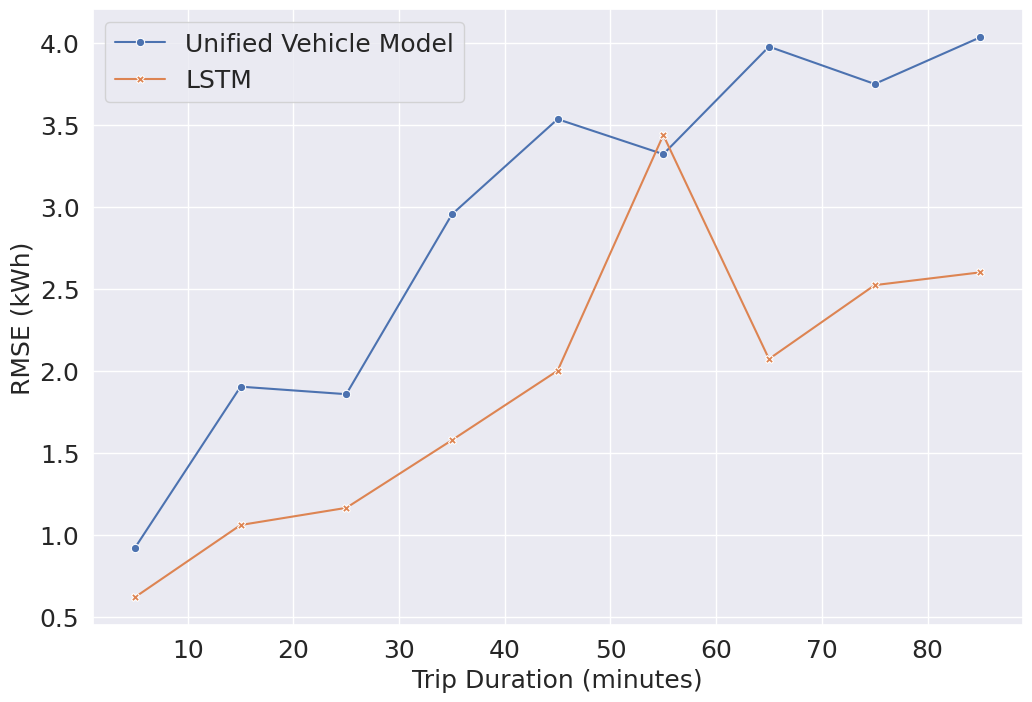

In [62]:
metrics_date = {'duration': [], 'model': [], 'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'variance': [], 'r2': [], 'std': []}
for name, group in result_df.groupby('duration_binned'):
    y = group['y'].values
    
    if len(group) <= 1:
        continue
        
    for pred in preds:
        y_pred = group[pred].values
        
        if pred == 'Individual Vehicle Model':
            continue
        
        mse = metrics.mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(y, y_pred)
        mape = metrics.mean_absolute_percentage_error(y, y_pred)
        variance = np.var(y_pred)
        r2 = metrics.r2_score(y, y_pred)
        std = np.std(y_pred)
        
        metrics_date['duration'].append(name)
        metrics_date['model'].append(pred)
        metrics_date['mse'].append(mse)
        metrics_date['rmse'].append(rmse)
        metrics_date['mae'].append(mae)
        metrics_date['mape'].append(mape)
        metrics_date['variance'].append(variance)
        metrics_date['r2'].append(r2)
        metrics_date['std'].append(std)

# Converting the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_date)

# Extract midpoints from temperature bins
metrics_df['duration_mid'] = metrics_df['duration'].apply(lambda x: x.mid)

plt.figure(figsize=(12, 8))
# Plot using the midpoints
sns.lineplot(
    data=metrics_df,
    x='duration_mid',
    y='rmse',
    hue='model',
    style='model',
    markers=True,
    dashes=False
)

plt.xlabel('Trip Duration (minutes)', fontsize=18)
plt.ylabel('RMSE (kWh)', fontsize=18)
plt.title('')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.savefig('pred-duration.svg', format='svg')
plt.show()

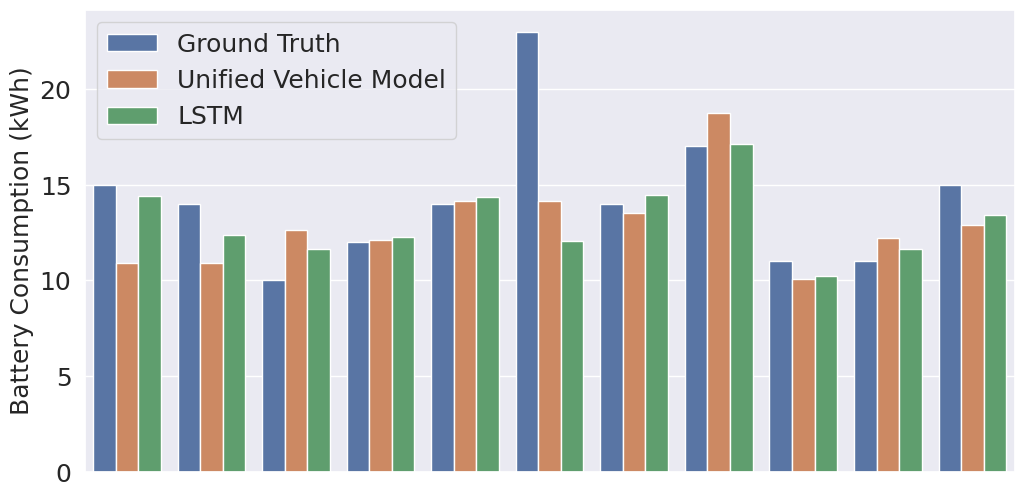

In [61]:

# Extract midpoints from temperature bins
result_df['duration_mid'] = result_df['duration_binned'].apply(lambda x: x.mid)
viz = result_df[result_df['duration_mid'] == 55].copy()
# viz.pivot_table(index='date', columns='model', values=['rmse', 'std', 'r2'])
viz = viz[['vehicle', 'y', 'Unified Vehicle Model', 'LSTM']].rename(columns={'y': 'Ground Truth'})

# Melt the DataFrame to long format for plotting
df_melted = viz.reset_index().melt(id_vars=['index'], value_vars=['Ground Truth', 'Unified Vehicle Model', 'LSTM'], 
                                  var_name='Model', value_name='Value')

# Plotting using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='Value', hue='Model', data=df_melted)

# Add titles and labels
plt.title('')
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Battery Consumption (kWh)', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(' ')

# Show plot
plt.savefig('outlier-duration.svg', format='svg')
plt.show()

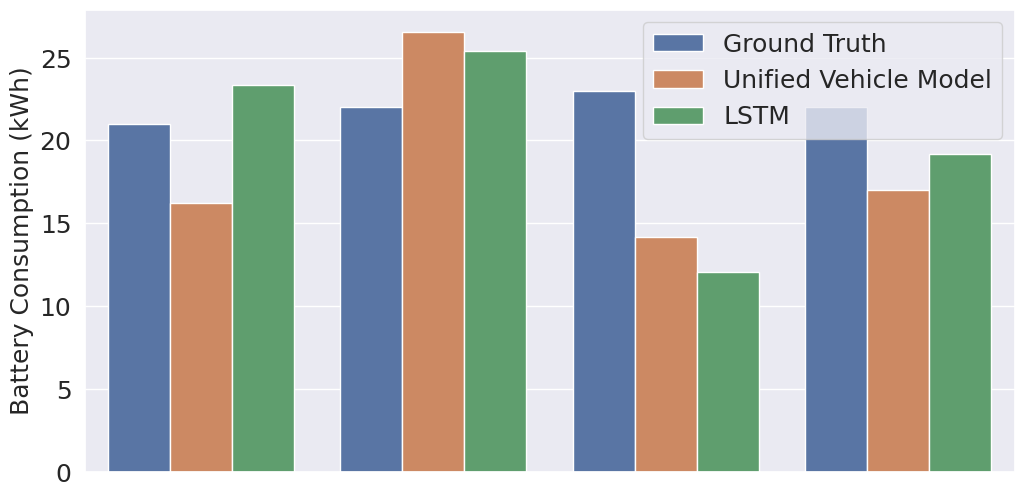

In [57]:
# Extract midpoints from temperature bins
viz = result_df[result_df['y_binned'] == '20 - 25'].copy()
# viz.pivot_table(index='date', columns='model', values=['rmse', 'std', 'r2'])
viz = viz[[ 'y', 'Unified Vehicle Model', 'LSTM']].rename(columns={'y': 'Ground Truth'})


# Melt the DataFrame to long format for plotting
df_melted = viz.reset_index().melt(id_vars=['index'], value_vars=['Ground Truth', 'Unified Vehicle Model', 'LSTM'], 
                                  var_name='Model', value_name='Value')

# Plotting using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='Value', hue='Model', data=df_melted)

# Add titles and labels
plt.title('')
plt.xlabel('')
plt.yticks(fontsize=18)
plt.ylabel('Battery Consumption (kWh)', fontsize=18)
plt.legend(fontsize=18)
plt.xticks(' ')

# Show plot
plt.savefig('outlier-value.svg', format='svg')
plt.show()

### Result by date

/tmp/ipykernel_239250/100410771.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in result_df.groupby('temperature_bin'):


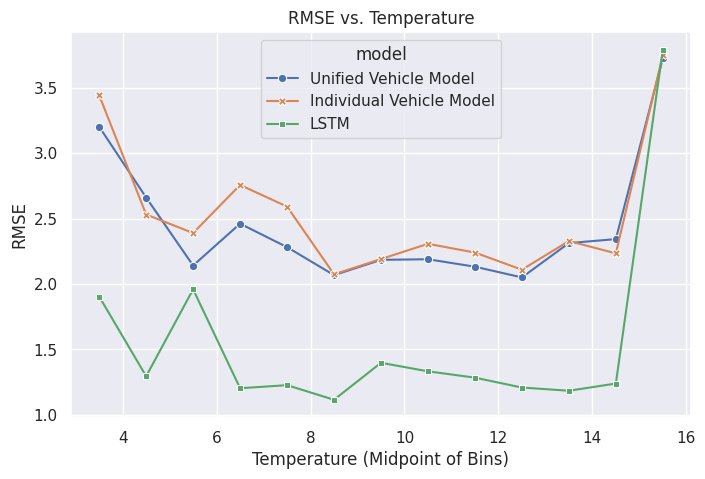

In [49]:
metrics_date = {'temperature': [], 'model': [], 'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'variance': [], 'r2': [], 'std': []}
for name, group in result_df.groupby('temperature_bin'):
    y = group['y'].values
    
    for pred in preds:
        y_pred = group[pred].values
        
        mse = metrics.mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(y, y_pred)
        mape = metrics.mean_absolute_percentage_error(y, y_pred)
        variance = np.var(y_pred)
        r2 = metrics.r2_score(y, y_pred)
        std = np.std(y_pred)
        
        metrics_date['temperature'].append(name)
        metrics_date['model'].append(pred)
        metrics_date['mse'].append(mse)
        metrics_date['rmse'].append(rmse)
        metrics_date['mae'].append(mae)
        metrics_date['mape'].append(mape)
        metrics_date['variance'].append(variance)
        metrics_date['r2'].append(r2)
        metrics_date['std'].append(std)

# Converting the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_date)

# Extract midpoints from temperature bins
metrics_df['temperature_mid'] = metrics_df['temperature'].apply(lambda x: x.mid)

# Plot using the midpoints
sns.lineplot(
    data=metrics_df,
    x='temperature_mid',
    y='rmse',
    hue='model',
    style='model',
    markers=True,
    dashes=False
)

plt.xlabel('Temperature (Midpoint of Bins)')
plt.ylabel('RMSE')
plt.title('RMSE vs. Temperature')
plt.show()

In [31]:
metrics_date = {'start_time': [], 'model': [], 'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'variance': [], 'r2': [], 'std': []}
for name, group in result_df.groupby('start_time_hour_bin'):
    y = group['y'].values
    
    for pred in preds:
        y_pred = group[pred].values
        
        mse = metrics.mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(y, y_pred)
        mape = metrics.mean_absolute_percentage_error(y, y_pred)
        variance = np.var(y_pred)
        r2 = metrics.r2_score(y, y_pred)
        std = np.std(y_pred)
        
        
        metrics_date['start_time'].append(name)
        metrics_date['model'].append(pred)
        metrics_date['mse'].append(mse)
        metrics_date['rmse'].append(rmse)
        metrics_date['mae'].append(mae)
        metrics_date['mape'].append(mape)
        metrics_date['variance'].append(variance)
        metrics_date['r2'].append(r2)
        metrics_date['std'].append(std)

# Converting the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_date)
metrics_df['start_time'] = metrics_df['start_time'].astype(str)

metrics_df

# sns.lineplot(data=metrics_df, x='start_time', y='rmse', hue='model', markers=True, dashes=False)
# # plt.savefig('comparison-date.png', format='png')
# plt.show()

,start_time,model,mse,rmse,mae,mape,variance,r2,std
0,04:00:00,Unified Vehicle Model,4.406456,2.099156,1.566756,2.382554e-01,3.458509,0.498186,1.859707
1,04:00:00,Individual Vehicle Model,5.808788,2.410143,1.779711,2.641070e-01,3.192727,0.338486,1.786820
2,04:00:00,LSTM,2.536109,1.592517,1.128212,1.711142e-01,4.448551,0.711184,2.109159
3,05:00:00,Unified Vehicle Model,3.854064,1.963177,1.656822,2.731816e-01,10.375262,0.611902,3.221065
4,05:00:00,Individual Vehicle Model,3.010841,1.735177,1.419107,2.341656e-01,8.699176,0.696813,2.949437
5,05:00:00,LSTM,0.781940,0.884274,0.704541,1.125090e-01,10.256214,0.921260,3.202532
6,06:00:00,Unified Vehicle Model,5.339347,2.310703,1.852551,2.104750e+13,8.746021,0.436465,2.957367
7,06:00:00,Individual Vehicle Model,5.807095,2.409791,1.907850,1.726874e+13,7.519364,0.387097,2.742146
8,06:00:00,LSTM,1.596264,1.263434,0.998677,5.925690e+13,8.992304,0.831524,2.998717
9,07:00:00,Unified Vehicle Model,5.168802,2.273500,1.757453,2.175210e-01,14.136872,0.721127,3.759903


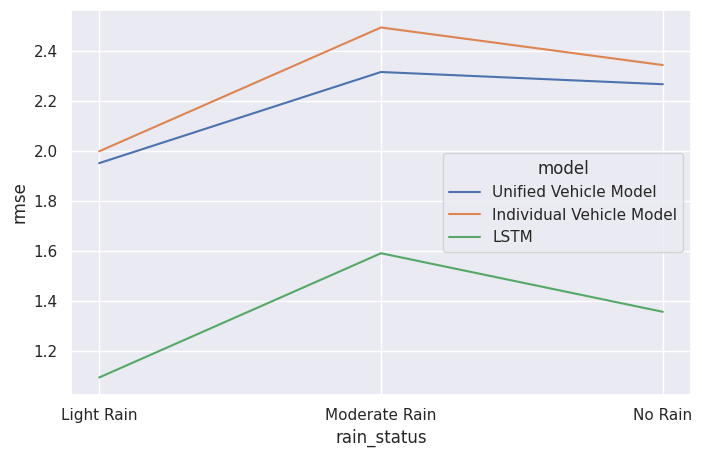

In [53]:
metrics_date = {'rain_status': [], 'model': [], 'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'variance': [], 'r2': [], 'std': []}
for name, group in result_df.groupby('precipitation_bin'):
    y = group['y'].values
    
    for pred in preds:
        y_pred = group[pred].values
        
        mse = metrics.mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(y, y_pred)
        mape = metrics.mean_absolute_percentage_error(y, y_pred)
        variance = np.var(y_pred)
        r2 = metrics.r2_score(y, y_pred)
        std = np.std(y_pred)
        
        metrics_date['rain_status'].append(name)
        metrics_date['model'].append(pred)
        metrics_date['mse'].append(mse)
        metrics_date['rmse'].append(rmse)
        metrics_date['mae'].append(mae)
        metrics_date['mape'].append(mape)
        metrics_date['variance'].append(variance)
        metrics_date['r2'].append(r2)
        metrics_date['std'].append(std)

# Converting the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_date)

sns.lineplot(data=metrics_df, x='rain_status', y='rmse', hue='model', markers=True, dashes=False)
plt.show()

### Result by vehicle

In [211]:
metrics_date = {'date': [], 'model': [], 'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'variance': [], 'r2': [], 'std': []}
for name, group in result_df.groupby('date'):
    y = group['y'].values
    
    for pred in preds:
        if pred == 'LSTM':
            continue
            
        y_pred = group[pred].values
        
        mse = metrics.mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(y, y_pred)
        mape = metrics.mean_absolute_percentage_error(y, y_pred)
        variance = np.var(y_pred)
        r2 = metrics.r2_score(y, y_pred)
        std = np.std(y_pred)
        
        metrics_date['date'].append(name)
        metrics_date['model'].append(pred)
        metrics_date['mse'].append(mse)
        metrics_date['rmse'].append(rmse)
        metrics_date['mae'].append(mae)
        metrics_date['mape'].append(mape)
        metrics_date['variance'].append(variance)
        metrics_date['r2'].append(r2)
        metrics_date['std'].append(std)

# Converting the dictionary to a DataFrame
metrics_df = pd.DataFrame(metrics_date)
metrics_df

,date,model,mse,rmse,mae,mape,variance,r2,std
0,2024-01-20,Unified Vehicle Model,6.170027,2.483954,1.904872,1.010934e+14,7.065657,0.394538,2.658130
1,2024-01-20,Individual Vehicle Model,7.258397,2.694141,2.011582,8.948709e+13,6.049992,0.287737,2.459673
2,2024-01-21,Unified Vehicle Model,6.274648,2.504925,2.051117,3.323505e-01,7.437115,0.340538,2.727108
3,2024-01-21,Individual Vehicle Model,6.624892,2.573887,2.125385,3.125507e-01,6.606181,0.303727,2.570249
4,2024-01-22,Unified Vehicle Model,6.131208,2.476128,1.838163,1.320650e+14,12.912032,0.702034,3.593332
5,2024-01-22,Individual Vehicle Model,7.453260,2.730066,2.027875,1.330084e+14,11.193350,0.637784,3.345646
6,2024-01-23,Unified Vehicle Model,6.773772,2.602647,1.967865,1.077513e+14,8.847138,0.477689,2.974414
7,2024-01-23,Individual Vehicle Model,6.256038,2.501207,1.881541,1.114724e+14,8.969419,0.517610,2.994899
8,2024-01-24,Unified Vehicle Model,5.784032,2.405002,1.954903,3.341263e-01,10.084105,0.531024,3.175548
9,2024-01-24,Individual Vehicle Model,6.473757,2.544358,2.137455,3.647000e-01,9.472520,0.475101,3.077746


In [63]:
# Pivot the DataFrame
pivot_df = metrics_df.pivot_table(index='date', columns='model', values=['rmse', 'std', 'r2'])

pivot_df.to_latex()

'\\begin{tabular}{lrrrrrrrrr}\n\\toprule\n & \\multicolumn{3}{r}{r2} & \\multicolumn{3}{r}{rmse} & \\multicolumn{3}{r}{std} \\\\\nmodel & Individual Vehicle Model & LSTM & Unified Vehicle Model & Individual Vehicle Model & LSTM & Unified Vehicle Model & Individual Vehicle Model & LSTM & Unified Vehicle Model \\\\\ndate &  &  &  &  &  &  &  &  &  \\\\\n\\midrule\n2024-02-03 & 0.908227 & 0.976641 & 0.945029 & 11.135655 & 5.618019 & 8.618400 & 42.202347 & 39.933314 & 41.516575 \\\\\n2024-02-04 & 0.704505 & 0.805736 & 0.813181 & 10.246851 & 8.308291 & 8.147531 & 20.677972 & 23.476046 & 19.765835 \\\\\n2024-02-06 & 0.546918 & 0.897093 & 0.815609 & 16.981298 & 8.092896 & 10.833104 & 33.025358 & 29.501863 & 30.182635 \\\\\n2024-02-07 & 0.833691 & 0.933387 & 0.923332 & 11.526387 & 7.294797 & 7.826010 & 35.891428 & 32.357779 & 33.074736 \\\\\n2024-02-08 & 0.633396 & 0.888185 & 0.828707 & 17.508608 & 9.669496 & 11.968030 & 29.047472 & 27.598931 & 27.122994 \\\\\n2024-02-09 & 0.799971 & 0.811564 

In [34]:
metrics_vehicle = {'vehicle': [], 'model': [], 'mse': [], 'rmse': [], 'mae': [], 'mape': [], 'variance': [], 'r2': [], 'std': []}
for name, group in result_df.groupby('vehicle'):
        
    y = group['y'].values
    
    for pred in preds:
        y_pred = group[pred].values
        mse = metrics.mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = metrics.mean_absolute_error(y, y_pred)
        mape = metrics.mean_absolute_percentage_error(y, y_pred)
        variance = np.var(y_pred)
        r2 = metrics.r2_score(y, y_pred)
        std = np.std(y_pred)
        
        n = 75281 # Number of samples
        p = 17 # Number of features

        adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
        
        metrics_vehicle['vehicle'].append(name)
        metrics_vehicle['model'].append(pred)
        metrics_vehicle['mse'].append(mse)
        metrics_vehicle['rmse'].append(rmse)
        metrics_vehicle['mae'].append(mae)
        metrics_vehicle['mape'].append(mape)
        metrics_vehicle['variance'].append(variance)
        metrics_vehicle['r2'].append(adjusted_r2)
        metrics_vehicle['std'].append(std)

# Converting the dictionary to a DataFrame
metrics_vehicle_df = pd.DataFrame(metrics_vehicle)
metrics_vehicle_df[['model', 'vehicle', 'rmse', 'r2', 'std']]

,model,vehicle,rmse,r2,std
0,Unified Vehicle Model,E301,1.845248,0.575392,2.213900
1,Individual Vehicle Model,E301,1.703390,0.638168,2.116261
2,LSTM,E301,1.409504,0.752252,2.146792
3,Unified Vehicle Model,E302,2.024050,0.433859,2.138730
4,Individual Vehicle Model,E302,2.126682,0.374989,2.157177
5,LSTM,E302,1.246323,0.785344,2.508514
6,Unified Vehicle Model,E304,2.293124,0.303501,2.554664
7,Individual Vehicle Model,E304,2.203611,0.356816,2.409301
8,LSTM,E304,1.175058,0.817113,2.845557
9,Unified Vehicle Model,E305,2.477670,-0.013887,2.263851


In [213]:
pivot_df = metrics_vehicle_df.pivot_table(index='vehicle', columns='model', values=['rmse', 'std', 'r2'])
pivot_df.to_latex()

'\\begin{tabular}{lrrrrrr}\n\\toprule\n & \\multicolumn{2}{r}{r2} & \\multicolumn{2}{r}{rmse} & \\multicolumn{2}{r}{std} \\\\\nmodel & Individual Vehicle Model & Unified Vehicle Model & Individual Vehicle Model & Unified Vehicle Model & Individual Vehicle Model & Unified Vehicle Model \\\\\nvehicle &  &  &  &  &  &  \\\\\n\\midrule\nE301 & 0.638250 & 0.575488 & 1.703390 & 1.845248 & 2.116261 & 2.213900 \\\\\nE302 & 0.375130 & 0.433987 & 2.126682 & 2.024050 & 2.157177 & 2.138730 \\\\\nE304 & 0.356962 & 0.303659 & 2.203611 & 2.293124 & 2.409301 & 2.554664 \\\\\nE305 & -0.014568 & -0.013658 & 2.478781 & 2.477670 & 2.275586 & 2.263851 \\\\\nE306 & 0.512990 & 0.506475 & 2.134721 & 2.148951 & 2.377029 & 2.432530 \\\\\nE307 & 0.368290 & 0.411737 & 2.726540 & 2.631109 & 2.718388 & 2.781707 \\\\\nE308 & 0.386950 & 0.432760 & 2.474019 & 2.379788 & 2.060463 & 2.130753 \\\\\nE309 & 0.183065 & 0.274178 & 2.213864 & 2.086760 & 1.967999 & 1.966367 \\\\\nE310 & 0.446428 & 0.442599 & 2.583811 & 2.59273

### Visualizing

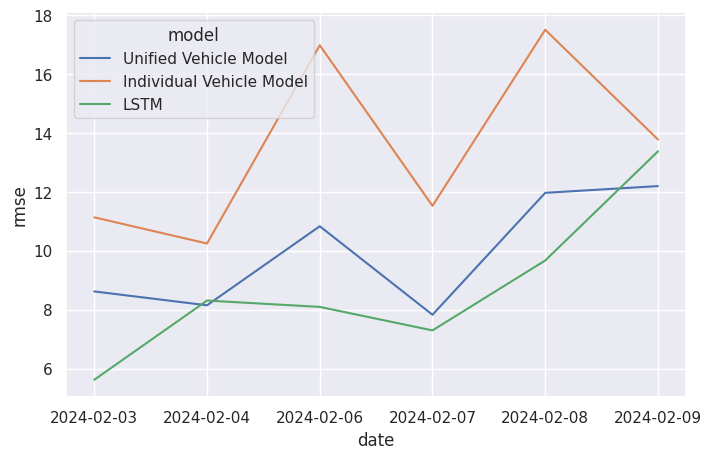

In [68]:
sns.lineplot(data=metrics_df, x='date', y='rmse', hue='model', markers=True, dashes=False)
plt.savefig('comparison-date.png', format='png')
plt.show()

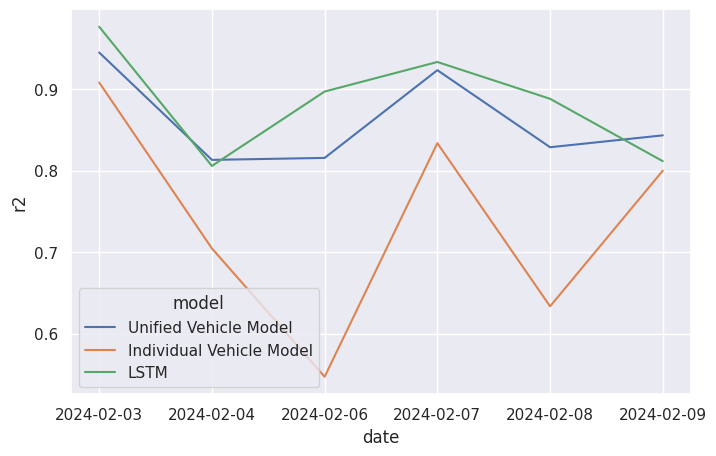

In [69]:
sns.lineplot(data=metrics_df, x='date', y='r2', hue='model', markers=True, dashes=False)
plt.savefig('comparison-r2-date.png', format='png')
plt.show()

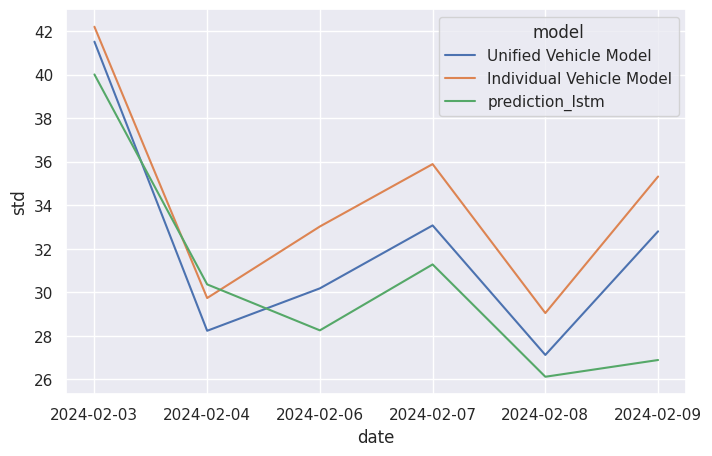

In [114]:
sns.lineplot(data=metrics_df, x='date', y='std', hue='model', markers=True, dashes=False)
plt.show()

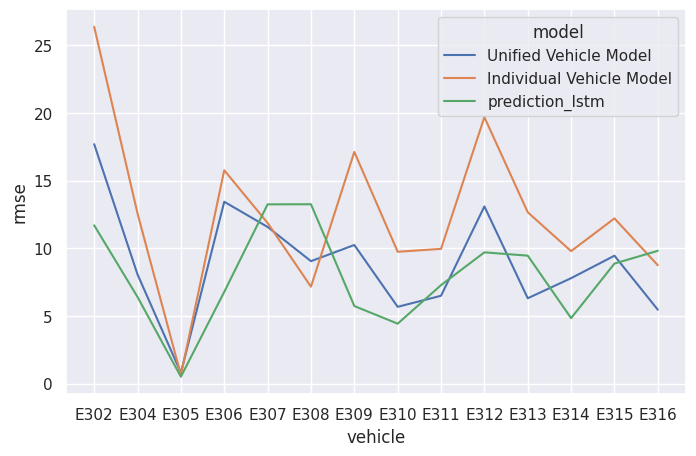

In [115]:
sns.lineplot(data=metrics_vehicle_df, x='vehicle', y='rmse', hue='model', markers=True, dashes=False)
plt.show()

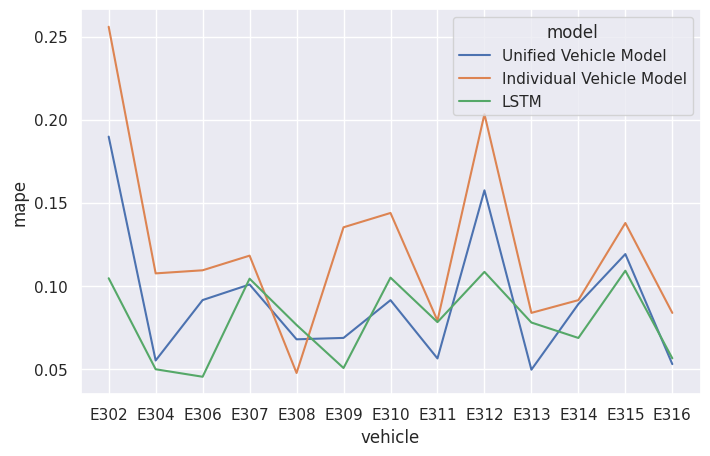

In [70]:
sns.lineplot(data=metrics_vehicle_df, x='vehicle', y='mape', hue='model', markers=True, dashes=False)
plt.show()